In [1]:
# Imports
import os
import shutil
import nibabel as nib
import numpy as np
import random
import distutils
from distutils import dir_util
from random import shuffle
from glob import glob
from nilearn.plotting import plot_roi, plot_epi

In [2]:
#%% Set current directory
os.chdir('/home/uziel/DISS')
root = './data_processed/ISLES2017/training'

In [3]:
# groups relevant sequences per subject
subjects_paths = sorted(os.listdir(root))
channels_per_subject = dict()
for i in range(len(subjects_paths)):
    s_path = os.path.join(root, subjects_paths[i])
    channels_per_subject[i] = sorted([os.path.join(s_path, x)
                                      for x in os.listdir(s_path)
                                      if 'clone' not in x])


In [4]:
# For each subjec, create n new ones (default=1),
# whose lesion region is randomly sampled.
clones_number = 1
for subject, entries in channels_per_subject.items():
    channels = [x for x in entries if "OT" not in x and "mask" not in x]
    mask = [x for x in entries if "mask" in x]
    label = [x for x in entries if "OT" in x]
    subject_path = os.path.dirname(channels[0])
    
    # load subject label
    label_img = nib.load(label[0])
    label_data = label_img.get_data()
    # load subejct mask
    mask_img = nib.load(mask[0])
    mask_name = os.path.basename(mask[0])
    
    # create new clones
    for i in range(clones_number):
        # create path to save clone data
        clone_path = os.path.join(subject_path, 'clone_V2_'+ str(i))
        if os.path.exists(clone_path): shutil.rmtree(clone_path)
        os.makedirs(clone_path)
        
        # create each clone channel
        for j in range(len(channels)):
            channel_img = nib.load(channels[j])
            channel_data = channel_img.get_data().copy()
            # get data withing roi (label)
            roi_data = channel_data[np.nonzero(label_data)]
            # new data follows gaussian distribution
            mean_value, std_value = [np.mean(roi_data), np.std(roi_data)]
            channel_data[np.nonzero(label_data)] = np.array([random.gauss(mean_value, std_value)
                                                             for _ in range(roi_data.shape[0])])
            # create modified channel for clone
            modified_channel = nib.Nifti1Image(channel_data, channel_img.affine)
            #TODO: Normalize image?
            # save clone channel
            channel_name = os.path.basename(channels[j])
            nib.save(modified_channel, os.path.join(clone_path, 'clone_V2_' + str(i) + '.' + channel_name))
        
        # save unaltered label for clone
        label_name = os.path.basename(label[0])
        nib.save(label_img, os.path.join(clone_path, 'clone_V2_' + str(i) + '.' + label_name))
        #save unaltered mask for clone
        nib.save(mask_img, os.path.join(clone_path, 'clone_V2_' + str(i) + '.' + mask_name))

    print("Subject " + str(subject) + " finished.")
            

Subject 0 finished.
Subject 1 finished.
Subject 2 finished.
Subject 3 finished.
Subject 4 finished.
Subject 5 finished.
Subject 6 finished.
Subject 7 finished.
Subject 8 finished.
Subject 9 finished.
Subject 10 finished.
Subject 11 finished.
Subject 12 finished.
Subject 13 finished.
Subject 14 finished.
Subject 15 finished.
Subject 16 finished.
Subject 17 finished.
Subject 18 finished.
Subject 19 finished.
Subject 20 finished.
Subject 21 finished.
Subject 22 finished.
Subject 23 finished.
Subject 24 finished.
Subject 25 finished.
Subject 26 finished.
Subject 27 finished.
Subject 28 finished.
Subject 29 finished.
Subject 30 finished.
Subject 31 finished.
Subject 32 finished.
Subject 33 finished.
Subject 34 finished.
Subject 35 finished.
Subject 36 finished.
Subject 37 finished.
Subject 38 finished.
Subject 39 finished.
Subject 40 finished.
Subject 41 finished.
Subject 42 finished.


In [5]:
def data_to_file(data, path):
    out = open(path, "w")
    for line in data:
        print >> out, line
    out.close()

In [6]:
###############################################################
##### FILES FOR DM_V1 (BASELINE + RANDOM LESION SAMPLING) #####
##### + TRANSFER LEARNING                                 #####
###############################################################
root = './ischleseg/deepmedic/versions'
root_base = './ischleseg/deepmedic/versions/DM_V1_base'
root_base_transfer = './ischleseg/deepmedic/versions/DM_V1_transfer_base'
# Copy directories from DM_V0
dirs = sorted(glob(os.path.join(root, 'DM_V0_[0-9]')))
dirs_transfer = sorted(glob(os.path.join(root, 'DM_V0_transfer_[0-9]')))

for i in range(len(dirs)):
    s_path = os.path.join(os.path.dirname(dirs[i]), 'DM_V1_' + str(i))
    s_path_transfer = os.path.join(os.path.dirname(dirs_transfer[i]),
                                   'DM_V1_transfer_' + str(i))

    if os.path.exists(s_path): shutil.rmtree(s_path)
    shutil.copytree(dirs[i], s_path)

    if os.path.exists(s_path_transfer): shutil.rmtree(s_path_transfer)
    shutil.copytree(dirs_transfer[i], s_path_transfer)

    distutils.dir_util.copy_tree(root_base, s_path)
    distutils.dir_util.copy_tree(root_base_transfer, s_path_transfer)
    
    train_path = os.path.join(s_path, 'configFiles/train')
    train_path_transfer = os.path.join(s_path_transfer, 'configFiles/train')
    
    # read subject codes
    subject_list = [os.path.dirname(line.strip()).split('/')[-1]
                    for line in open(os.path.join(train_path, 'trainChannels_ADC.cfg') , 'r')]
    
    root = './data_processed/ISLES2017/training'
    channels = {}
    # channels - sequences os.path.join('../../../../../../', x) needed for deepmedic
    channels['Channels_ADC'] = [os.path.join('../../../../../../', y)
                                for x in os.walk(root)
                                for y in glob(os.path.join(x[0], '*ADC*.nii.gz'))
                                if os.path.dirname(x[0]).split('/')[-1] in subject_list or
                                os.path.basename(x[0]) in subject_list]
    channels['Channels_MTT'] = [os.path.join('../../../../../../', y)
                                for x in os.walk(root)
                                for y in glob(os.path.join(x[0], '*MTT*.nii.gz'))
                                if os.path.dirname(x[0]).split('/')[-1] in subject_list or
                                os.path.basename(x[0]) in subject_list]
    channels['Channels_rCBF'] = [os.path.join('../../../../../../', y)
                                 for x in os.walk(root)
                                 for y in glob(os.path.join(x[0], '*rCBF*.nii.gz'))
                                 if os.path.dirname(x[0]).split('/')[-1] in subject_list or
                                 os.path.basename(x[0]) in subject_list]
    channels['Channels_rCBV'] = [os.path.join('../../../../../../', y)
                                 for x in os.walk(root)
                                 for y in glob(os.path.join(x[0], '*rCBV*.nii.gz'))
                                 if os.path.dirname(x[0]).split('/')[-1] in subject_list or
                                 os.path.basename(x[0]) in subject_list]
    channels['Channels_Tmax'] = [os.path.join('../../../../../../', y)
                                 for x in os.walk(root)
                                 for y in glob(os.path.join(x[0], '*Tmax*.nii.gz'))
                                 if os.path.dirname(x[0]).split('/')[-1] in subject_list or
                                 os.path.basename(x[0]) in subject_list]
    channels['Channels_TTP'] = [os.path.join('../../../../../../', y)
                                for x in os.walk(root)
                                for y in glob(os.path.join(x[0], '*TTP*.nii.gz'))
                                if os.path.dirname(x[0]).split('/')[-1] in subject_list or
                                os.path.basename(x[0]) in subject_list]
    # labels
    channels['GtLabels'] = [os.path.join('../../../../../../', y)
                            for x in os.walk(root)
                            for y in glob(os.path.join(x[0], '*OT*.nii.gz'))
                            if os.path.dirname(x[0]).split('/')[-1] in subject_list or
                            os.path.basename(x[0]) in subject_list]
    # masks
    channels['RoiMasks'] = [os.path.join('../../../../../../', y)
                            for x in os.walk(root)
                            for y in glob(os.path.join(x[0], '*mask.nii.gz'))
                            if os.path.dirname(x[0]).split('/')[-1] in subject_list or
                            os.path.basename(x[0]) in subject_list]

    for name, files in channels.iteritems():
        # save train channel files
        data_to_file(files, os.path.join(train_path, 'train' + name + '.cfg'))
        data_to_file(files, os.path.join(train_path_transfer, 'train' + name + '.cfg'))

# modelConfig,cfg, trainConfig.cfg and testConfig.cfg must be added and modified manually.

Subject: 25. Channel: Channels_rCBF. Shape: (168, 193, 171)
Subject: 29. Channel: Channels_TTP. Shape: (171, 183, 134)
Subject: 4. Channel: Channels_TTP. Shape: (164, 185, 147)
Subject: 19. Channel: Channels_Tmax. Shape: (168, 189, 147)
Subject: 20. Channel: Channels_ADC. Shape: (166, 180, 134)


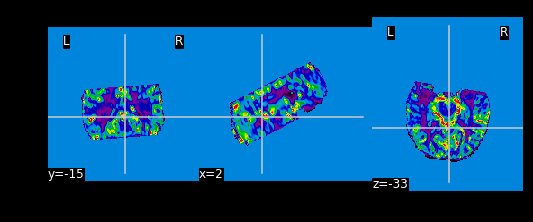

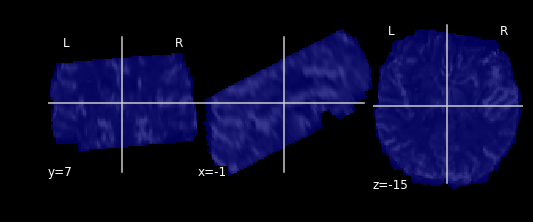

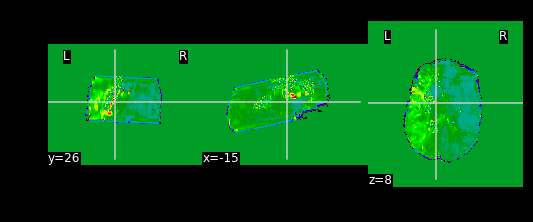

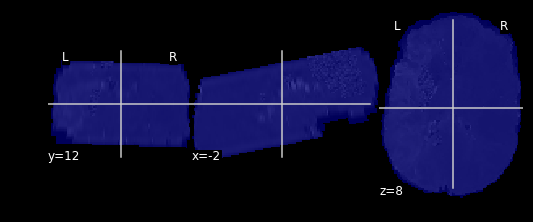

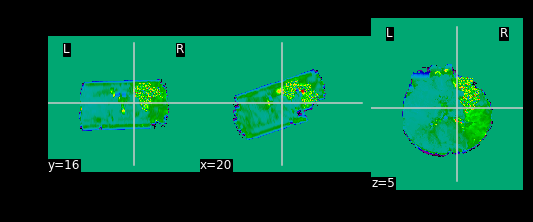

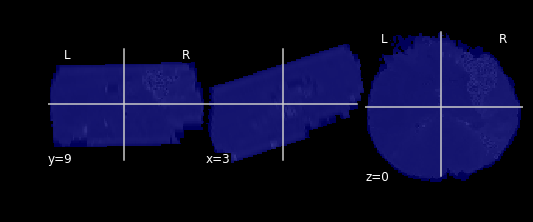

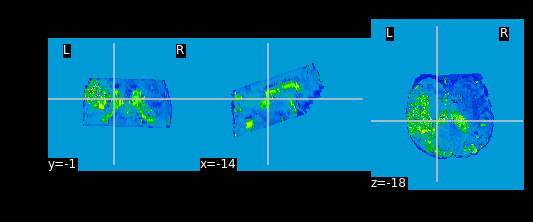

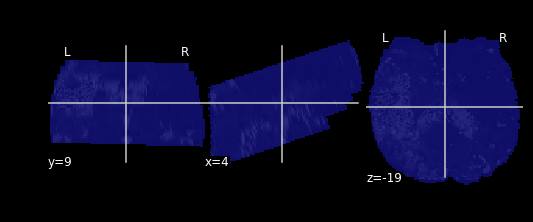

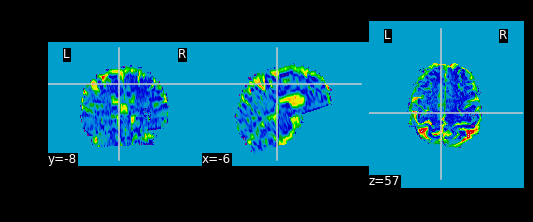

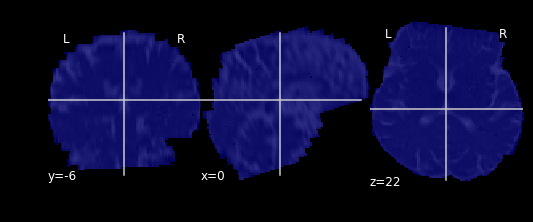

In [7]:
################################
##### TEST RESULTING FILES #####
################################

# Get training subjects
subject_list = [os.path.split(os.path.dirname(x[0]))[1] for x in subject_list]
subject_list.append('clone_V2_0') #add clone subdir name
#%% Generate files listing all images per channel
os.chdir('/home/uziel/DISS')
root = './data_processed/ISLES2017/training'

channels = {}
# channels - sequences os.path.join('../../../../../../', x) needed for deepmedic
channels['Channels_ADC'] = [y for x in os.walk(root)
                            for y in glob(os.path.join(x[0], '*ADC*.nii.gz'))
                           if os.path.basename(x[0]) in subject_list]
channels['Channels_MTT'] = [y for x in os.walk(root)
                            for y in glob(os.path.join(x[0], '*MTT*.nii.gz'))
                           if os.path.basename(x[0]) in subject_list]
channels['Channels_rCBF'] = [y for x in os.walk(root)
                             for y in glob(os.path.join(x[0], '*rCBF*.nii.gz'))
                           if os.path.basename(x[0]) in subject_list]
channels['Channels_rCBV'] = [y for x in os.walk(root)
                             for y in glob(os.path.join(x[0], '*rCBV*.nii.gz'))
                           if os.path.basename(x[0]) in subject_list]
channels['Channels_Tmax'] = [y for x in os.walk(root)
                             for y in glob(os.path.join(x[0], '*Tmax*.nii.gz'))
                           if os.path.basename(x[0]) in subject_list]
channels['Channels_TTP'] = [y for x in os.walk(root)
                            for y in glob(os.path.join(x[0], '*TTP*.nii.gz'))
                           if os.path.basename(x[0]) in subject_list]
# labels
channels['GtLabels'] = [y for x in os.walk(root)
                        for y in glob(os.path.join(x[0], '*OT*.nii.gz'))
                           if os.path.basename(x[0]) in subject_list]
# masks
channels['RoiMasks'] = [y for x in os.walk(root)
                        for y in glob(os.path.join(x[0], '*mask.nii.gz'))
                           if os.path.basename(x[0]) in subject_list]

# take 5 random subjects and check their images
indices = range(len(channels['Channels_ADC']))
shuffle(indices)
indices = indices[:5]

for i in indices:
    # load a random channel of subject i
    channel = random.choice([x for x in channels.keys() if 'Mask' not in x and "Label" not in x])
    #img = nib.load(channels[channel][i])
    img = nib.load(channels[channel][i])
    mask = nib.load(channels['RoiMasks'][i])
    print('Subject: ' + str(i) + '. Channel: ' + str(channel) + '. Shape: ' + str(img.shape))
    plot_epi(img) # plot_epi(img, cut_coords=(0,0,0)) -> use to see co-registered channels per subject
    plot_roi(mask, img)